In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_27801/3909921149.py:18: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def contract_to_unisphere(
    x: torch.Tensor,
    ord: float = 2,
    eps: float = 1e-6,
    derivative: bool = False,
    cdf_lb: float = 0.1,
    num_bins: int = 1000,
):  
    x_pdf, x_pos = torch.histogram(x[:, 0].cpu(), bins=num_bins)
    y_pdf, y_pos = torch.histogram(x[:, 1].cpu(), bins=num_bins)
    z_pdf, z_pos = torch.histogram(x[:, 2].cpu(), bins=num_bins)
    x_cdf, x_pos = torch.cumsum(x_pdf, dim=0) / x.shape[0], x_pos[:-1]
    y_cdf, y_pos = torch.cumsum(y_pdf, dim=0) / x.shape[0], y_pos[:-1]
    z_cdf, z_pos = torch.cumsum(z_pdf, dim=0) / x.shape[0], z_pos[:-1]

    aabb = torch.tensor([
        x_pos[x_cdf > cdf_lb].min(),
        y_pos[y_cdf > cdf_lb].min(),
        z_pos[z_cdf > cdf_lb].min(),
        x_pos[x_cdf > 1 - cdf_lb].min(),
        y_pos[y_cdf > 1 - cdf_lb].min(),
        z_pos[z_cdf > 1 - cdf_lb].min(),
    ], device=x.device)
    aabb_min, aabb_max = torch.split(aabb, aabb.shape[0] // 2, dim=-1)
    x = (x - aabb_min) / (aabb_max - aabb_min)
    x = x * 2 - 1  # aabb is at [-1, 1]
    mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
    mask = mag.squeeze(-1) > 1

    if derivative:
        dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
            1 / mag**3 - (2 * mag - 1) / mag**4
        )
        dev[~mask] = 1.0
        dev = torch.clamp(dev, min=eps)
        return dev
    else:
        x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
        x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
        return x

def get_flowid(frames, flows):
    N, _, H, W = frames.shape
    flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
    flow_ids[0] = torch.arange(H * W).view(H, W)
    last_id = H * W

    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_y = grid_y.to(device=frames.device)
    grid_x = grid_x.to(device=frames.device)
    diff_threshold = frames.max().item() * 0.1
    for i in tqdm(range(1, N), desc="Assigning flow ids"):
        x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
        y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
        mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        # cut off flow when error is significant
        diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < diff_threshold
        flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

        unassigned = (flow_ids[i] == -1)
        flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
        last_id += unassigned.sum()
    
    return flow_ids

def voxelization(flow_ids, in_feats_rgb, in_feats_coord, voxel_size, xyz_min=None, contract=False):
    with torch.no_grad():
        # automatically determine the voxel size
        _, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
        feats_coord = torch_scatter.scatter(in_feats_coord, unq_inv_t, dim=0, reduce='mean')

        # contract to unit sphere
        # decide aabb according to density
        if contract:
            feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
        if xyz_min is None:
            xyz_min = torch.min(feats_coord, dim=0).values
        voxel_size = torch.tensor([voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
        voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
        feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')

        unq_inv = unq_inv_xyz[unq_inv_t]

        return unq_inv

def warp_flow(frames, past_flows):
    
    N, _, H, W = frames.shape
    flow_new = past_flows[:, :2].clone()
    flow_new[:, 0, :, :] += torch.arange(W, device=flow_new.device)
    flow_new[:, 1, :, :] += torch.arange(H, device=flow_new.device)[:, None]
    # resides flow_new to [-1, 1]
    flow_new[:, 0] = (flow_new[:, 0] / (W - 1) - 0.5) * 2
    flow_new[:, 1] = (flow_new[:, 1] / (H - 1) - 0.5) * 2
    frame_warp = F.grid_sample(frames, flow_new.permute(0, 2, 3, 1), mode='bicubic', padding_mode='zeros', align_corners=True)

    return frame_warp

def compute_fwdbwd_mask(fwd_flow, bwd_flow, alpha=0.1):

    bwd2fwd_flow = warp_flow(bwd_flow, fwd_flow)
    fwd_lr_error = torch.linalg.norm(fwd_flow + bwd2fwd_flow, dim=1)
    fwd_mask = fwd_lr_error < alpha * (torch.linalg.norm(fwd_flow, dim=1) + torch.linalg.norm(bwd2fwd_flow, dim=1)) + alpha

    fwd2bwd_flow = warp_flow(fwd_flow, bwd_flow)
    bwd_lr_error = torch.linalg.norm(bwd_flow + fwd2bwd_flow, dim=1)
    bwd_mask = bwd_lr_error < alpha * (torch.linalg.norm(bwd_flow, dim=1) + torch.linalg.norm(fwd2bwd_flow, dim=1)) + alpha

    return fwd_mask, bwd_mask

In [3]:
output_dir = "../workdir/sceneflow/sceneflow_highres_test_lmr_0.2_gmr_0.1"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
    data_parser.voxel_size, data_parser.use_raft = None, True
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    frames, coords_w, c2ws = data_parser.load_video(frame_ids);
    flows, past_flows = data_parser.load_flow(frame_ids, future_flow=True, past_flow=True, gts=frames);
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 81808.15it/s]


[INFO] frame indexes:  28 29 ... 126 127


Loading Data: 100%|██████████| 300/300 [00:03<00:00, 80.99it/s]
/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Flows:   0%|          | 0/300 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/evaluation/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/data1/yang_liu/python_workspace/IC-Light/evaluation/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data1/yang_liu/python_workspace/IC-Light/evaluation/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args.

[INFO] frame size (512, 960) resize to (512, 960) and centercrop to (512, 960)


Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 611.78it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 19759923 / 49152000


Loading Flows: 100%|██████████| 300/300 [00:10<00:00, 27.56it/s]


[INFO] frame size (512, 960) resize to (512, 960) and centercrop to (512, 960)
[INFO] frame size (512, 960) resize to (512, 960) and centercrop to (512, 960)


## 0. Cluster Points according to Flow

In [ ]:
# assign each pixel a flow id
N, _, H, W = frames.shape
flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
flow_ids[0] = torch.arange(H * W).view(H, W)
last_id = H * W

grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
grid_y = grid_y.to(device=frames.device)
grid_x = grid_x.to(device=frames.device)
diff_threshold = frames.max().item() * 0.1
for i in tqdm(range(1, N), desc="Assigning flow ids"):
    x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
    y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
    mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
    # cut off flow when error is significant
    diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < 0.1
    flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

    unassigned = (flow_ids[i] == -1)
    flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
    last_id += unassigned.sum()

print(f"Total number of flow ids: {last_id} / {N * H * W}")

Assigning flow ids:   0%|          | 0/99 [00:00<?, ?it/s]

Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 506.82it/s]

Total number of flow ids: 19759923 / 49152000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 959.5, 511.5, -0.5)

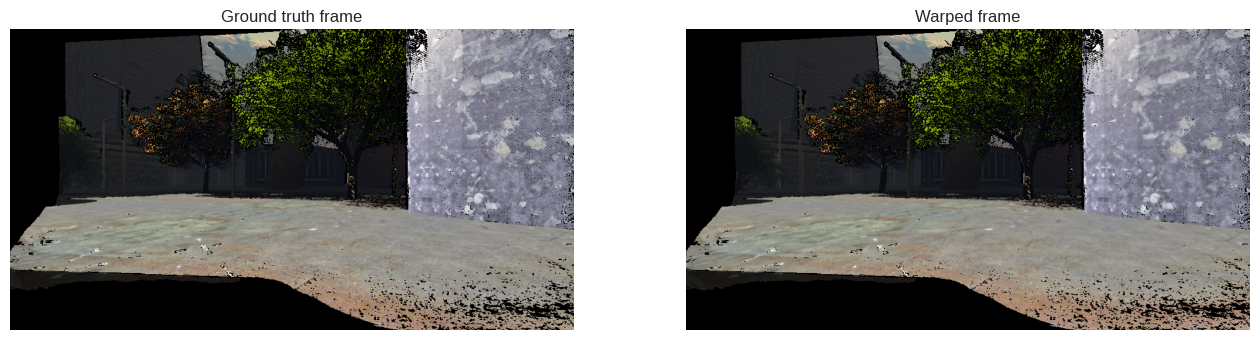

In [ ]:
i = random.randint(1, len(frame_ids) - 1)
# i = 1
frame_warp_gt = frames[i:i+1].clone()
frame_warp = warp_flow(frames[i-1:i], past_flows[i:i+1])
_, mask_bwd = compute_fwdbwd_mask(flows[i-1:i], past_flows[i:i+1], alpha=0.1)
mask_bwd &= (frame_warp - frame_warp_gt).abs().max(dim=1).values < 0.1
frame_warp[0, :, ~mask_bwd[0]] = 0
frame_warp_gt[0, :, ~mask_bwd[0]] = 0
frame_warp = frame_warp[0].permute(1, 2, 0).cpu().numpy()
frame_warp_gt = frame_warp_gt[0].permute(1, 2, 0).cpu().numpy()

# x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
# y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
# mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
# frame_warp = torch.zeros_like(frames[i])
# frame_warp[:, y[mask], x[mask]] = frames[i-1, :, grid_y[mask], grid_x[mask]]
# frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
# frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

# frame_warp[:, grid_y[mask], grid_x[mask]] = frames[i-1, :, y[mask], x[mask]]
# frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
# frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame_warp_gt)
plt.title("Ground truth frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(frame_warp)
plt.title("Warped frame")
plt.axis("off")

In [ ]:
flow_ids = flow_ids.reshape(-1)
feats_rgb = frames.permute(0, 2, 3, 1).reshape(-1, 3)
feats_coord = coords_w.permute(0, 2, 3, 1).reshape(-1, 3)
_, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_t, dim=0, reduce='mean')
feats_coord = torch_scatter.scatter(feats_coord, unq_inv_t, dim=0, reduce='max')
# new_frames = feats_rgb[unq_inv_t].reshape(N, H, W, 3).permute(0, 3, 1, 2)
# data_parser.unq_inv = unq_inv_t

# contract to unit sphere
# decide aabb according to density
# feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
# voxel_size = torch.tensor([1e-3] * 3, dtype=feats_coord.dtype, device=feats_coord.device)

voxel_size = torch.tensor([data_parser.voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
xyz_min = torch.min(feats_coord, dim=0).values
voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
voxel_coords = torch.cat([voxel_coords, torch.div(feats_rgb, 2 / 255, rounding_mode='floor')], dim=1)

feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')
print(f"Total number of unique voxels: {feats_rgb.shape[0]} / {N * H * W}")

unq_inv = unq_inv_xyz[unq_inv_t]
new_frames = feats_rgb[unq_inv].reshape(N, H, W, 3).permute(0, 3, 1, 2)
# del unq_inv_t, unq_inv_xyz

Total number of unique voxels: 13782005 / 49152000


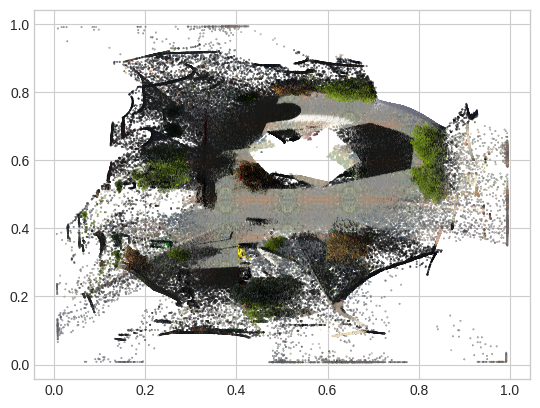

In [ ]:
interval = 50
pcd_xyz = feats_coord.cpu().numpy()[::interval]
pcd_rgb = feats_rgb.cpu().numpy()[::interval]
# mask = (pcd_xyz[:, 0] > -100) & (pcd_xyz[:, 0] < 200) & (pcd_xyz[:, 1] > -100) & (pcd_xyz[:, 1] < 200)
# pcd_xyz = pcd_xyz[mask]
# pcd_rgb = pcd_rgb[mask]
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=pcd_rgb, s=0.1)
# plt.xlim(0, 150)
# plt.ylim(-50, 150)
plt.show()

(-0.5, 959.5, 511.5, -0.5)

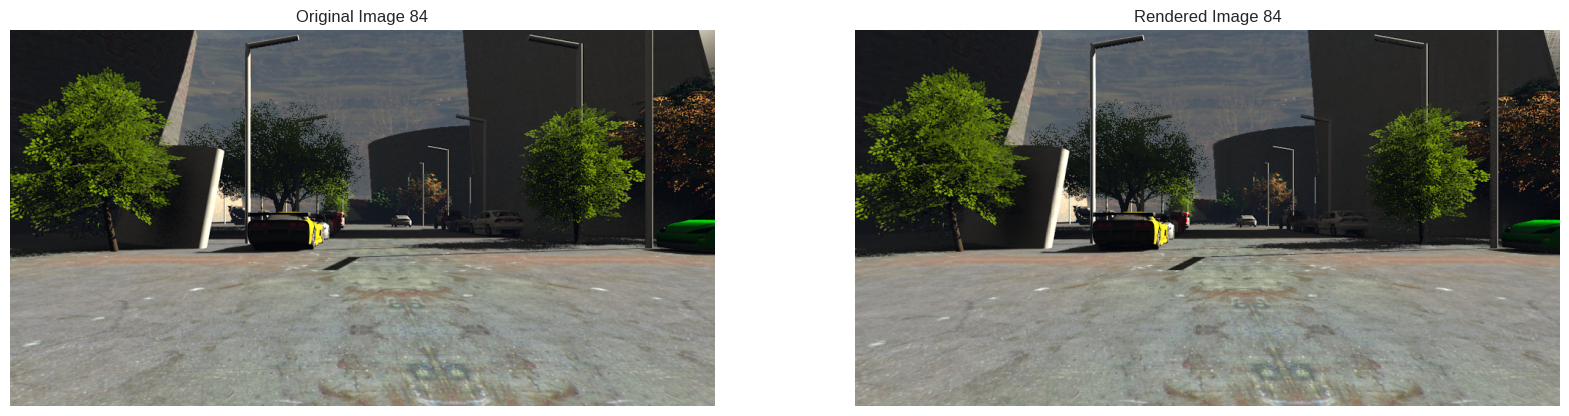

In [ ]:
idx = random.randint(0, len(frame_ids) - 1)
# idx = 1
pil_img = frames[idx].cpu().numpy().transpose(1, 2, 0)
rendered_img = new_frames[idx].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title(f'Original Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title(f'Rendered Image {idx}')
plt.axis('off')

## 1. Optimization

In [4]:
from torch import nn
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, ssim, color_correct

max_sh_degree = 3
lambda_dssim = 0.2
lambda_flow = 0.8
lambda_exp = 0.8
feature_lr = 0.05
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0
iterations = 70

/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output_gt.gif')
org_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0

_, mask_bwd = compute_fwdbwd_mask(flows[:-1], past_flows[1:])
org_images_warp = warp_flow(org_images[:-1], past_flows[1:])
mask_bwd &= (org_images_warp - org_images[1:]).abs().max(dim=1).values < org_images.max().item() * 0.1
mask_bwd = mask_bwd[:, None, ...].repeat(1, 3, 1, 1)

pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

In [6]:
exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

Optimizing: 100%|██████████| 70/70 [00:21<00:00,  3.26it/s, loss=0.039706]


Text(0.5, 1.0, 'Loss curve')

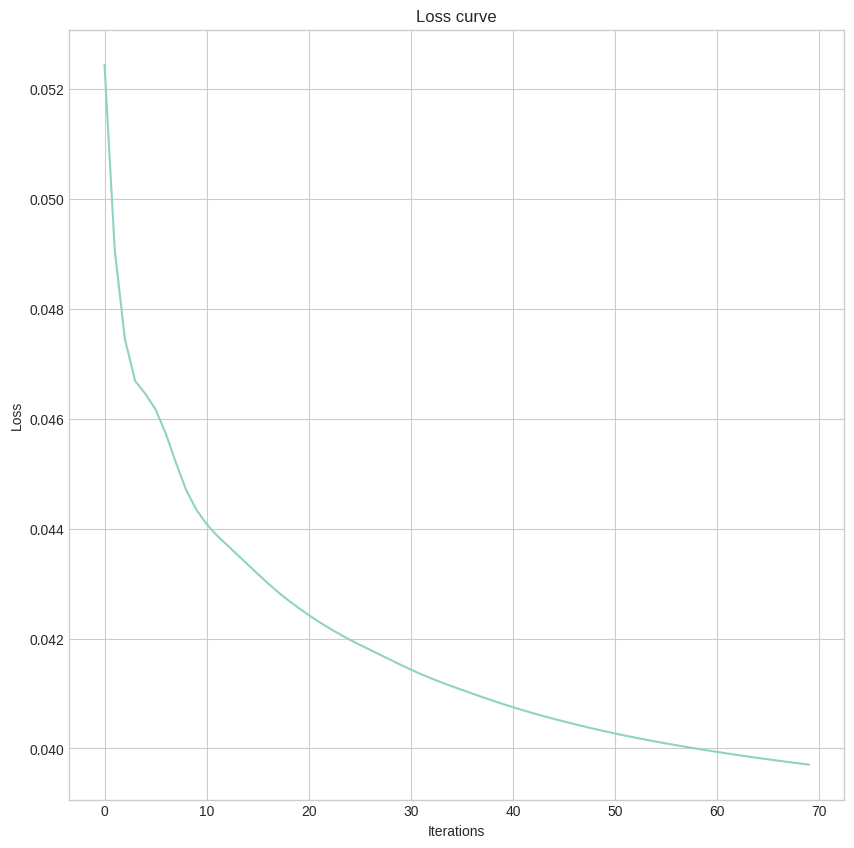

In [7]:
first_iter = 1
loss_list = []
pbar = tqdm(total=iterations, desc="Optimizing")
for i in tqdm(range(first_iter, iterations + 1), desc="Optimizing"):
    # update learning rate
    for param_group in exposure_optimizer.param_groups:
        param_group['lr'] = exposure_scheduler_args(i)

    # features = torch.cat((features_dc, features_rest), dim=1).transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
    
    images = torch.bmm(edited_images.permute(0, 2, 3, 1).reshape(N, H*W, -1), exposure[:, :3, :3]) + exposure[:, None, :3, 3]
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

    loss_photometric = l1_loss(images, edited_images)

    images_warp = warp_flow(images[:-1], past_flows[1:])
    # images_warp[~mask_bwd] = 0 * images_warp[~mask_bwd]s
    # images[1:][~mask_bwd] = 0 * images[1:][~mask_bwd]
    loss_flow = l1_loss(images_warp[mask_bwd], images[1:][mask_bwd])
    # Lssim_flow = 1.0 - ssim(images_warp, images[1:])
    # loss_flow = (1.0 - lambda_dssim) * Ll1_flow + lambda_dssim * Lssim_flow

    loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

    loss_list.append(loss.item())

    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
    )
    pbar.update()

    loss.backward()

    exposure_optimizer.step()
    exposure_optimizer.zero_grad(set_to_none = True)

    # torch.cuda.empty_cache()

pbar.close()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve")

In [8]:
with torch.no_grad():
    edited_images = torch.bmm(edited_images.permute(0, 2, 3, 1).reshape(N, H*W, -1), exposure[:, :3, :3]) + exposure[:, None, :3, 3]
    edited_images = torch.clamp(edited_images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
    pil_tensor = edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='max')
    print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N * H * W}")

    # xyz = torch_scatter.scatter(coords_w.permute(0, 2, 3, 1).reshape(N*H*W, -1), data_parser.unq_inv, dim=0, reduce='mean')
    # dir_pp = xyz[:, None, :] - c2ws[None, :, :3, 3]
    # del frames, coords_w, c2ws
    # dir_pp = dir_pp / torch.linalg.norm(dir_pp, dim=-1, keepdim=True)

fused_color = RGB2SH(pil_tensor.requires_grad_(True))
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

# features = torch.zeros((fused_color.shape[0], 3, (max_sh_degree + 1) ** 2)).float().to(fused_color.device)
# features[:, :3, 0 ] = fused_color
# features_dc = nn.Parameter(features[:,:,0:1].transpose(1, 2).contiguous().requires_grad_(True))
# features_rest = nn.Parameter(features[:,:,1:].transpose(1, 2).contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
    # {'params': [features_rest], 'lr': feature_lr / 20.0, "name": "f_rest"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

Total number of unique voxels: 19759923 / 49152000


Optimizing: 100%|██████████| 70/70 [02:30<00:00,  2.15s/it, loss=0.019279, loss_flow=0.004283, loss_photometric=0.079262]


Text(0.5, 1.0, 'Loss curve')

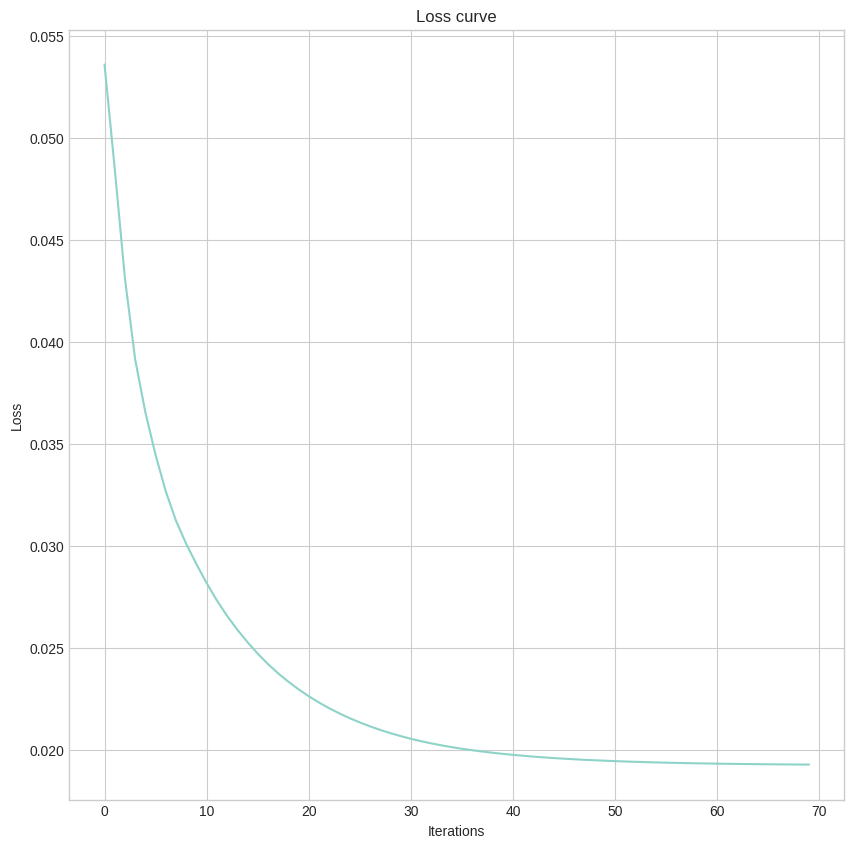

In [9]:
first_iter = 1
loss_list = []
pbar = tqdm(total=iterations, desc="Optimizing")
for i in tqdm(range(first_iter, iterations + 1), desc="Optimizing"):
    # update learning rate
    for param_group in exposure_optimizer.param_groups:
        param_group['lr'] = exposure_scheduler_args(i)

    # features = torch.cat((features_dc, features_rest), dim=1).transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
    
    images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
    
    Ll1 = l1_loss(images, edited_images)
    Lssim = 1.0 - ssim(images, edited_images)
    loss_photometric = (1.0 - lambda_dssim) * Ll1 + lambda_dssim * Lssim

    images_warp = warp_flow(images[:-1], past_flows[1:])
    # images_warp[~mask_bwd] = 0 * images_warp[~mask_bwd]s
    # images[1:][~mask_bwd] = 0 * images[1:][~mask_bwd]
    loss_flow = l1_loss(images_warp[mask_bwd], images[1:][mask_bwd])
    # Lssim_flow = 1.0 - ssim(images_warp, images[1:])
    # loss_flow = (1.0 - lambda_dssim) * Ll1_flow + lambda_dssim * Lssim_flow

    loss = (1 - lambda_flow) * loss_photometric + lambda_flow * loss_flow

    loss_list.append(loss.item())

    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

    loss.backward()

    optimizer.step()
    optimizer.zero_grad(set_to_none = True)

    # torch.cuda.empty_cache()

pbar.close()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve")

In [10]:
images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
# images = torch.bmm(images, exposure[:, :3, :3]) + exposure[:, None, :3, 3]
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
save_name = f"opt_lr_{feature_lr}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_it{iterations}_loss_{loss_list[-1]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/sceneflow/sceneflow_highres_test_lmr_0.2_gmr_0.1/opt_lr_0.05_lambda_flow_0.8_lambda_exp_0.8_it70_loss_0.019/output.gif


0

In [11]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 511.5, -0.5)

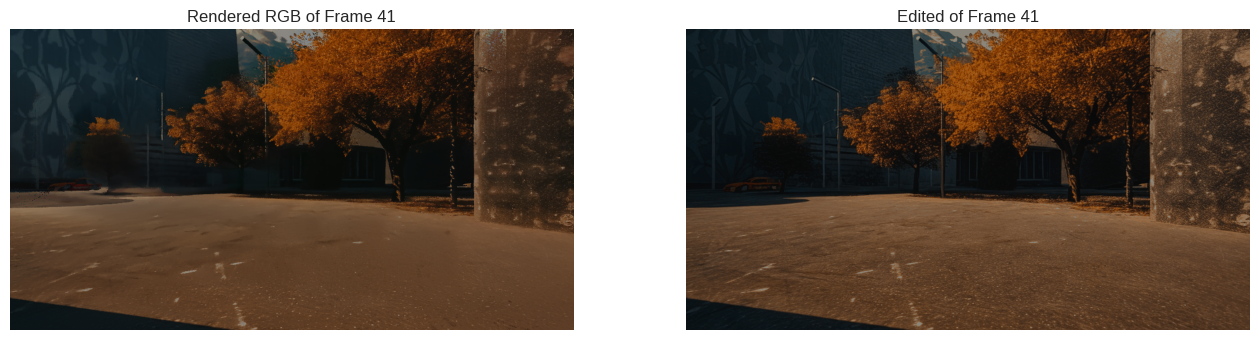

In [12]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
idx = 41
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
plt.axis("off")